In [52]:
# !pip install tqdm
# !pip install pydicom
# !pip install scikit-image
# !pip install --upgrade pillow
# !pip install SimpleITK

In [54]:
# needed libraries
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
import json
import pydicom
import numpy as np
import SimpleITK as sitk
import cv2 as cv

In [53]:
# import function from skullStrip.py
from skullStrip import skullStripping

# Pre-processing

This pre-processing flow is meant for data downloaded directly from the ADNI website and assumes that the organization of the downloaded files has not been changed, furthermore the ```.csv``` describing the image collection must also de downloaded from the ADNI website.

The pre-processed images will be saved at ```<dataset_path>/ADNI_PNG/```.

In [3]:
# define the path of the image collection and the .csv file describing the collection
dataset_path = "../MRI_AX/"
csv_path = dataset_path + "MRI_AX_5_14_2022.csv"

# create directory where the pre-processed images will be saved
png_dir = dataset_path + "ADNI_PNG/"
os.makedirs(png_dir, exist_ok=True)

In [4]:
# read .csv file
csv_file = pd.read_csv(csv_path)
csv_file.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I307644,941_S_4764,EMCI,F,83,22,MRI,localizer,Original,6/01/2012,DCM,5/13/2022
1,I431035,941_S_4764,EMCI,F,85,30,MRI,localizer,Original,6/16/2014,DCM,5/13/2022
2,I307655,941_S_4764,EMCI,F,83,22,MRI,ADNI_gre_field_mapping,Original,6/01/2012,DCM,5/13/2022
3,I376042,941_S_4764,EMCI,F,84,28,MRI,localizer,Original,6/10/2013,DCM,5/13/2022
4,I325113,941_S_4764,EMCI,F,83,24,MRI,localizer,Original,8/20/2012,DCM,5/13/2022


In [5]:
# acquire relevant data from the .csv file (image name and class)
info = [csv_file["Image Data ID"], csv_file["Group"]]

In [95]:
# get all files
files = sorted(glob(dataset_path + "ADNI/*/*/*/*/*.dcm"))
print("number of files:", len(files))

# remove irrelevant files
print("removing calibration scans...")
files = [k for k in files if "alibration" not in k]
print("number of files:", len(files))
new_files = files

number of files: 71027
removing calibration scans...
number of files: 19848


In [58]:
wrong_files = []

id = 0

# count number of images in each class
caseDict = {"CN": 0, "EMCI": 0, "MCI": 0, "LMCI": 0, "AD": 0}

for file in tqdm(new_files):
    
    # discover to which class the image belongs
    id = file.split("_")[-1][:-4]
    idx = csv_file.index[csv_file["Image Data ID"] == id].to_list()[0]

    group = csv_file["Group"][idx]

    # pre-processed image file name
    filename = png_dir + file.split("/")[-1][:-4] + "_" + group + ".png"

    try:
        # converts to png
        ds = pydicom.dcmread(file)
        new_image = ds.pixel_array.astype(np.float32)
        scaled_image = np.maximum(new_image, 0) / new_image.max()

        # skull stripping
        img = skullStripping(scaled_image)

        # bias correction (N4 algorithm)
        imgSitk = sitk.GetImageFromArray(img.astype(np.float32))
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(imgSitk)
        log_bias_field = corrector.GetLogBiasFieldAsImage(imgSitk)
        corrected_image_full_resolution = imgSitk / sitk.Exp(log_bias_field)

        imgSitk = sitk.GetArrayFromImage(corrected_image_full_resolution)

        # converts to rgb
        # start = time.time()
        rgb_img = np.zeros((3, imgSitk.shape[0], imgSitk.shape[1]))
        rgb_img[::] = imgSitk
        rgb_img = np.transpose(rgb_img, [1, 2, 0])

        # saves image
        cv.imwrite(filename, rgb_img * 255)
        caseDict[group] += 1
    except:
        wrong_files.append(filename)

In [59]:
# print data distribution
print(caseDict)
sb.set_theme(style="darkgrid")
palette_color = sb.color_palette("muted")
plt.pie(caseDict.values(), labels=caseDict.keys(), colors=palette_color, autopct="%.0f%%")
plt.title("Grau de demência do paciente em cada imagem", fontdict={"fontsize": 16}, pad=16)

plt.savefig(dataset_path + "corrected distribution", bbox_inches="tight", dpi=300)
plt.show()

# identify which files failed to be processed
print(len(wrong_files), " wrong files")

textfile = open(dataset_path + "wrongFiles.txt", "w")
for element in wrong_files:
    textfile.write(element + "\n")
textfile.close()

# save data distribution
with open(dataset_path + "distribution.json", "w") as write_file:
    json.dump(caseDict, write_file, indent=4)

## Step-by-step pre-processing example

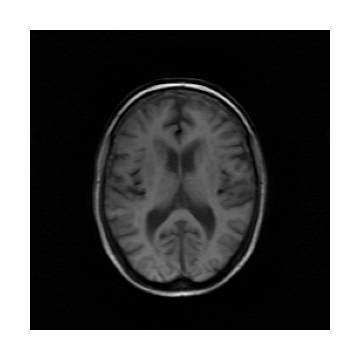

In [120]:
# choose an image file
i = 4 
file = new_files[i]

# convert to png
ds = pydicom.dcmread(file)
new_image = ds.pixel_array.astype(np.float32)
scaled_image = np.maximum(new_image, 0) / new_image.max()

# plot original image
fig = plt.figure( figsize=(1,1), dpi=my_dpi )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(scaled_image,'gray')
plt.grid(False)
plt.savefig(dataset_path + "original.png", bbox_inches="tight", dpi=300, pad_inches=0)

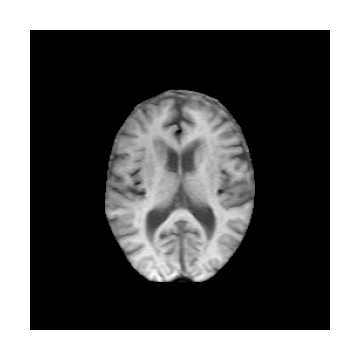

In [121]:
# skull stripping
img = skullStripping(scaled_image)

# plot skull stripped image
fig = plt.figure( figsize=(1,1), dpi=my_dpi )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(img,'gray')
plt.grid(False)
plt.savefig(dataset_path + "skullstrip.png", bbox_inches="tight", dpi=300, pad_inches=0)

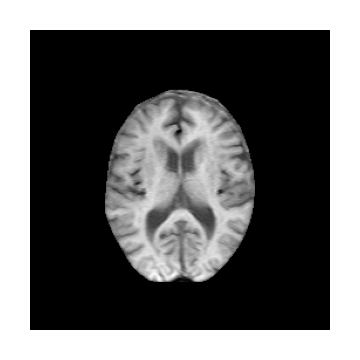

In [122]:
# bias correction
imgSitk = sitk.GetImageFromArray(img.astype(np.float32))
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrected_image = corrector.Execute(imgSitk)
log_bias_field = corrector.GetLogBiasFieldAsImage(imgSitk)
corrected_image_full_resolution = imgSitk / sitk.Exp(log_bias_field)

imgSitk = sitk.GetArrayFromImage(corrected_image_full_resolution)

# plot bias corrected image
fig = plt.figure( figsize=(1,1), dpi=my_dpi )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(imgSitk,'gray')
plt.grid(False)
plt.savefig(dataset_path + "biasfieldcorrected.png", bbox_inches="tight", dpi=300, pad_inches=0)

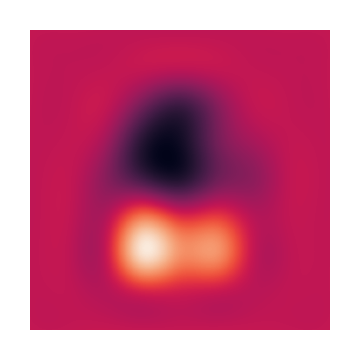

In [123]:
# plot bias field
fig = plt.figure( figsize=(1,1), dpi=my_dpi )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(sitk.GetArrayFromImage( log_bias_field ))
plt.grid(False)
plt.savefig(dataset_path + "biasfield.png", bbox_inches="tight", dpi=300, pad_inches=0)